## Introdução

&emsp; O intuito do projeto é a partir de uma base de dados com fotos dos personagens da série os Simpson e criar um classificador que, ao receber uma foto, consiga identificar a qual personagem ela se refere. Além disso, busca-se analisar os resultados e verificar se estes fazem sentido com base no que se vê na base de dados.

In [ ]:
%matplotlib inline
import opendatasets as od
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import random
import keras
from keras import layers, models, callbacks
from keras.layers import Dense, Dropout, BatchNormalization
from functools import partial
import tensorflow as tf
import tensorflow_hub as hub
import h5py
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import decimal
import pprint
from sklearn.metrics import classification_report
import pickle
from keras.utils.np_utils import to_categorical
plt.style.use('seaborn')

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


## Leitura dos Dados e Análise Exploratória

&emsp;Primeiro se baixa o dataset do Kaggle para o computador local utilizando o código abaixo.

In [ ]:
#Somente rodar se se deseja baixar os mais de 1 GB de imagens e arquivos do dataset.

#dataset = 'https://www.kaggle.com/alexattia/the-simpsons-characters-dataset'
#od.download(dataset)

&emsp;Após o download, é possível perceber que além da pasta contendo o dataset, também há um arquivo csv que quantifica o número de personagens e o número de imagens totais para cada personagem, conforme demonstrado na tabela abaixo. Além disso, é possível observar que existem $20933$ imagens no total e $47$ personagens diferentes listados neste arquivo. Já que para processar e analisar todas estas imagens se demoraria uma quantidade de tempo e recursos computacionais muito grande, foi decidido diminuir o número de personagens a serem clasificados para somente os $8$ com a maior quantidade de imagens disponíveis.

In [ ]:
df = pd.read_csv('number_pic_char.csv')  #lendo o arquivo csv
print('O numero total de imagens é de '+ str(sum(df.total)))  #número total de imagens
print('O numero total de personagens é de '+ str(len(df.index)))  #número total de personagens listados

df.head()

O numero total de imagens é de 20933
O numero total de personagens é de 47


,Unnamed: 0,name,total,train,test,bounding_box
0,0,Homer Simpson,2246,1909,337,612
1,1,Ned Flanders,1454,1236,218,595
2,2,Moe Szyslak,1452,1234,218,215
3,3,Lisa Simpson,1354,1151,203,562
4,4,Bart Simpson,1342,1141,201,554


In [ ]:
df = df.sort_values(by=['total'], ascending=False)  #se coloca o df ordenado por número total de imagens
df_novo = df[df.index<8]
print('O numero total de imagens é de '+ str(sum(df_novo.total)))  #número total de imagens
print('O numero total de personagens é de '+ str(len(df_novo.index)))  #conferindo se o número total de personagens é 8

df_novo.head(8)

O numero total de imagens é de 11539
O numero total de personagens é de 8


,Unnamed: 0,name,total,train,test,bounding_box
0,0,Homer Simpson,2246,1909,337,612
1,1,Ned Flanders,1454,1236,218,595
2,2,Moe Szyslak,1452,1234,218,215
3,3,Lisa Simpson,1354,1151,203,562
4,4,Bart Simpson,1342,1141,201,554
5,5,Marge Simpson,1291,1097,194,557
6,6,Krusty The Clown,1206,1025,181,226
7,7,Principal Skinner,1194,1015,179,506


&emsp;Com estas simplificações no dataset é possível fazer uma análise mais profunda da base de dados que será usada para treinar os modelos de classificação utilizados. Por exemplo, percebe-se que as colunas de 'train' e de 'test' são simplesmente uma separação de $85%$ das imagens totais para trainamento e $15%$ para teste. Além disso, é possível ver que o Homer Simpson possui uma quantidade significativamente maior de imagens em comparação a todos os outros personagens. Isto pode indicar que alguns dos modelos treinados poderão ter um recall muito bom do Homer Simpson, mas que acabe classificando muitos dos outros personagens como Homer também devido a maior disponibilidade de imagens deste personagem. Ao observar todos os personagens que se buscará classificar também é possível perceber que alguns são mais semelhantes que outros. Por exemplo, a Lisa Simpson e o Bart Simpson possuem características semelhantes como as faces, o cabelo espetado e a cor do cabelo sendo a mesma que do resto da face. Isto pode indicar uma correlação alta entre estes dois personagens. Em contraste, o Krusty The Clown difere dos outros personagens em relação a cor da face além de possuir um cabelo bem característico, o que pode significar que ele seja mais fácil dos modelos identificarem.

In [ ]:
porcentagem = []

for a in range(len(df_novo.index)):
    porcentagem.append(round(df['train'].iloc[a]/df['total'].iloc[a],2))  #Coloca-se na lista de porcentagens quantos porcento das imagens totais são consideradas de treinamento
    if df['train'].iloc[a] + df['test'].iloc[a] != df['total'].iloc[a]:
        print(a)  #Verifica-se se as imagens de teste correspondem ao restante daa porcentagem para chegar em 1
    
porcentagem

[0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85]

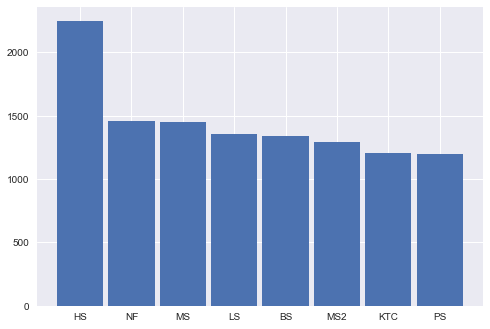

['HS = Homer Simpson', 'NF = Ned Flanders', 'MS = Moe Szyslak', 'LS = Lisa Simpson', 'BS = Bart Simpson', 'MS2 = Marge Simpson', 'KTC = Krusty The Clown', 'PS = Principal Skinner']


In [ ]:
all_characters_name = df_novo['name'].unique().tolist() #Coloca o nome de todos os personagens em uma lista
nomes_siglas = []
association_list = []
#O 'for' abaixo coloca o nome dos personagens em siglas para melhor visualização no gráfico de barra
for name in all_characters_name:
    nome_append = ''.join([c for c in name if c.isupper()])
    if nome_append not in nomes_siglas:
        nomes_siglas.append(nome_append)
    else:
        nomes_siglas.append(nome_append+'2')

#Este 'for' coloca em uma lista qual nome cada sigla indica
for a,b in zip(nomes_siglas,all_characters_name):
    association_list.append(a +' = '+ b)

#Aqui se plota o gráfico
num_im = df_novo['total'].tolist() #Coloca o número de imagens total de cada personagem em uma lista
fig = plt.figure()
x_bar = nomes_siglas
y_bar = num_im
plt.bar(x_bar,y_bar,align='center',width=0.9)
plt.show()

print(association_list)

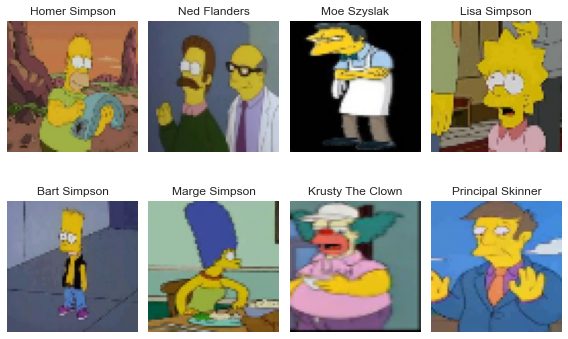

In [ ]:
DATADIR_Examples = r'C:\Users\GF63\Documents\Insper\Semestre 6\Machine Learning\Projeto Final Simpsons R\kaggle_simpson_testset'

#Abaixo é criado uma lista com os nomes dos personagems tudo em minúsculo e com '_' ao invez de espaço pois isto facilitará a manipulação dos dados
all_characters = []
for a in all_characters_name:
    all_characters.append(a.lower().replace(' ', '_'))  #Coloca em uma nova lista o nome dos personagens em minúsculo e com _ ao invez de espaço, isto ajuda em análises futuras
num_classes = len(all_characters)  #Define o número de categorias (personagens)

i=0

for name in all_characters:
    path = os.path.join(DATADIR_Examples,name+'_1.jpg')
    img = cv2.imread(path)
    img_resize = cv2.resize(img, (64, 64)) 
    plt.subplot(2, 4, i+1)
    plt.imshow(cv2.cvtColor(img_resize, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(all_characters_name[all_characters.index(name)])
    i += 1

plt.tight_layout()
plt.show()

## Preparação dos Dados

&emsp;Após a exploração dos dados, é preciso preparar as imagens e separa-los em treinamento e teste. Primeiramente, foi determinado que a cor das imagens são importantes para determinar qual personagem é qual, visto que características como a cor do cabelo, cor da pele, cor da roupa, etc. podem ser essenciais para se obter um modelo de classificação mais preciso. Para poder aplicar as imagens aos algarismos de machine learning é preciso que elas estejam na forma de arrays, com cada pixel sendo representado por três valores (no caso de uma imagem com cor). Além disso, é necessário que todas as imagens possuam as mesmas dimensões. Sobre isto, é importante mencionar que o computador utilizado para rodar os códigos não conseguia lidar com imagens acima de 100x100 pixels (o código para o CNN não rodava). Portanto, este limite foi o tamanho determinado para as imagens.

&emsp;Além disso, cada imagem precisa ter um label associado. Este label foi criado de duas formas diferentes, utilizando o integer encoding e o one hot encoding. No caso do integer encoding, é possível que alguns modelos acabem associando a grandeza dos números representativos de cada classe com ordens de importância. Há vezes que isto é desejado, mas neste caso, com a classificação de personagens diferentes, não é desejada esta associação. Em contraste, o one hot encoding separa claramente estes labels o que pode significar que as variáveis categoricas sejam processadas mais adequadamente pelo algarismo. Adicionalmente, foi escolhido uma separação de 85% das imagens de cada personagem para o conjunto de treinamento e 15% para o conjunto de teste. Esta separação foi proposta pelo autor do dataset, como visto no dataframe apresentado anteriormente, e foi vista como sendo adequada, pois se mantém uma quantidade apropriada de imagens para cada personagem para se testar.

In [ ]:
DATADIR = r"C:\Users\GF63\Documents\Insper\Semestre 6\Machine Learning\Projeto Final Simpsons R\simpsons_dataset"
img_size = 100

In [ ]:
training_data = []
testing_data = []
training_percentage = 0.85

def create_data():
    for category in all_characters:  #Iterar sobre cada um dos 8 personagens escolhidos
        path = os.path.join(DATADIR,category)  #Criar um path para cada personagem
        class_num = all_characters.index(category) #Usado como label antes do one hot encoding
        all_images_and_labels = []
        for img in os.listdir(path):  #Itera sobre cada imagem
            img_array = cv2.imread(os.path.join(path,img))  #Converter a imagem em array
            img_rgb = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)  #Converte de RGB para BGR pois o cv2 utiliza BGR
            new_array = cv2.resize(img_rgb, (img_size,img_size))  #Coloca-se a imagem no tamanho desejado
            all_images_and_labels.append([new_array,class_num])
            
        num_list = int(decimal.Decimal(0.85*len(all_images_and_labels)).quantize(0, decimal.ROUND_HALF_UP))  #Usa-se este módulo por causa do ROUND_HALF_UP, para ficar igual ao dataframe previamente mostrado
        for entry in all_images_and_labels[:num_list]:
            training_data.append(entry)  #Se coloca as primeiras 85% das imagens na lista de treinamento
        for entry in all_images_and_labels[-len(all_images_and_labels)+num_list:]:
            testing_data.append(entry)  #Se coloca as últimas 15% das imagens na lista de treinamento
        
            
create_data()

In [ ]:
#Aqui se embaralha as listas de treinamento e de teste para não haver um padrão para a ordem das imagens e se separa em X e y
random.shuffle(testing_data)
random.shuffle(training_data)
X_train = []; y_train = []; X_test = []; y_test = []

for x,y in training_data:
    X_train.append(x)
    y_train.append(y)
    
for x,y in testing_data:
    X_test.append(x)
    y_test.append(y)

In [ ]:
#Se transforma os y com integer encoding para one hot encoding
range_encoding = []
for ent in range(num_classes):
    range_encoding.append(ent)

yCat = tf.keras.utils.to_categorical(range_encoding, num_classes=num_classes)

In [ ]:
y_test_cat = []
y_train_cat = []

for num in y_test:
    y_test_cat.append(yCat[num])
    
for num in y_train:
    y_train_cat.append(yCat[num])

Exemplo de imagens de treinamento


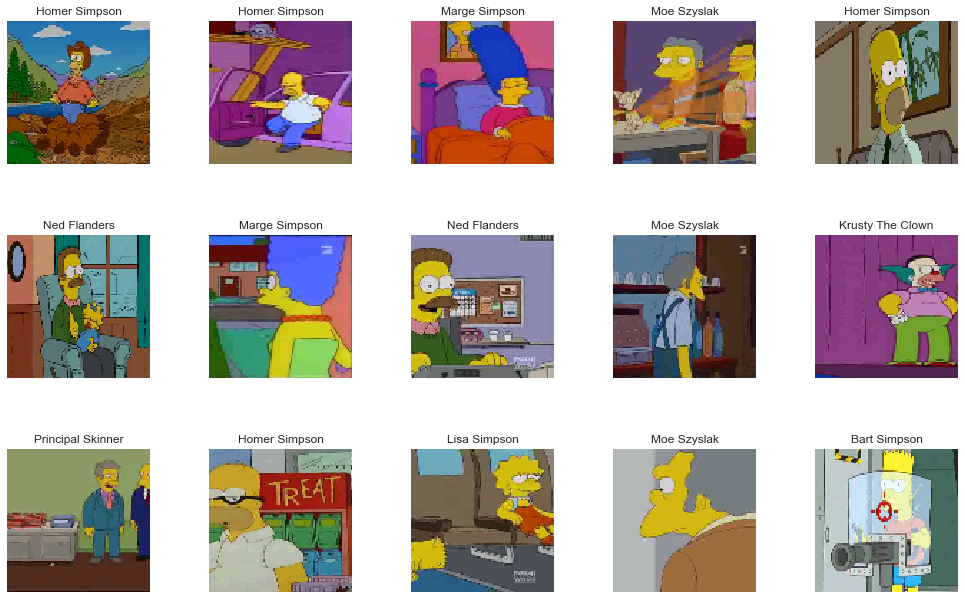

In [ ]:
#Imagens do dataset de treinamento com seus respectivos labels para vizualização e verificação da associação entre X e y.
n_rows = 3
n_cols = 5
plt.figure(figsize=(n_cols * 3.5, n_rows * 3.5))
print('Exemplo de imagens de treinamento')
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], interpolation="nearest")
        plt.axis("off")
        name_char = all_characters_name[y_train_cat[index].tolist().index(1)]
        plt.title(name_char, fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Exemplo de imagens de teste


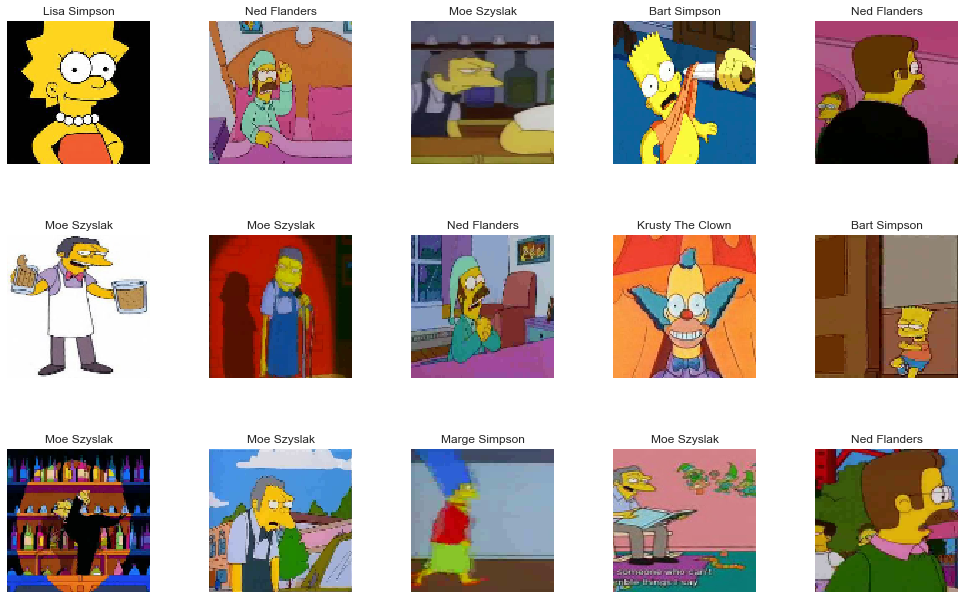

In [ ]:
#Imagens do dataset de teste com seus respectivos labels para vizualização e verificação da associação entre X e y.
n_rows = 3
n_cols = 5
plt.figure(figsize=(n_cols * 3.5, n_rows * 3.5))
print('Exemplo de imagens de teste')
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_test[index], interpolation="nearest")
        plt.axis("off")
        name_char = all_characters_name[y_test_cat[index].tolist().index(1)]
        plt.title(name_char, fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [ ]:
#Este código se roda quando se está criando uma nova separação de treinamento e teste
#Salva-se os X e y de teste e treinamento em um arquivo hdf5 para leitura mais rápido dos dados quando for rodar o código novamente
with h5py.File(r'C:\Users\GF63\Documents\Insper\Semestre 6\Machine Learning\Projeto Final Simpsons R\\'+ str(img_size)+'_'+str(img_size)+'_3.hdf5', 'w') as hdf:
    hdf.create_dataset('X_train', data=X_train)
    hdf.create_dataset('y_train', data=y_train)
    hdf.create_dataset('y_train_cat', data=y_train_cat)
    hdf.create_dataset('X_test', data=X_test)
    hdf.create_dataset('y_test', data=y_test)
    hdf.create_dataset('y_test_cat', data=y_test_cat)

In [ ]:
#Este código se roda quando já se tem o arquivo com a separação de treinamento e teste
#Leitura dos dados arquivados em hdf5
with h5py.File(str(img_size)+'_'+str(img_size)+'_3.hdf5', 'r') as hdf:
    ls = list(hdf.keys())
    X_test_hd5 = hdf.get(ls[0]);X_train_hd5 = hdf.get(ls[1]);y_test_hd5 = hdf.get(ls[2]);y_test_hd5_cat = hdf.get(ls[3]);y_train_hd5 = hdf.get(ls[4]);y_train_hd5_cat = hdf.get(ls[5])
    X_train = np.array(X_train_hd5);X_test = np.array(X_test_hd5);y_train = np.array(y_train_hd5);y_test = np.array(y_test_hd5);y_train_cat = np.array(y_train_hd5_cat);y_test_cat = np.array(y_test_hd5_cat)

In [ ]:
#Funções para análise dos resultados

def plot_confusion_matrix(cm, classes, normalize=True, title='Matriz de confusão', cmap=plt.cm.Greens):  
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def resultados_modelo(y_test_model,y_pred_model):
    print('A acurácia deste modelo foi de ' + str(round(accuracy_score(y_test_model, y_pred_model),4)*100) + '%')
    print('\n')
    class_rep = classification_report(y_test_model, y_pred_model, target_names=all_characters_name)
    print(class_rep)
    cnf_matrix = confusion_matrix(y_test_model,y_pred_model)
    plot_confusion_matrix(cnf_matrix, classes=all_characters_name)
    

## Treinamento dos Modelos e Resultados

&emsp;Agora com tudo organizado é possível aplicar os modelos de machine learning. Foi escolhido treinar quatro modelos diferentes, dois do random forest classifier e dois usando o CNN pré-treinado do Res-Net 50 retirado do keras no formato de feature vector. Cada classificador será treinado uma vez com os labels em formato de integer encoding e outra com os labels no formato de one hot encoding. Isto porque, como explicado anteriormente, se espera que o one hot encoding obtenha um desempenho melhor, mas isto nem sempre é o caso.

### Random Forest com Integer Encoding

In [ ]:
model_RF = RandomForestClassifier(n_jobs=-1, random_state=42)
model_RF.fit(X_train.reshape(X_train.shape[0], -1), y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
y_pred_RF = model_RF.predict(X_test.reshape(X_test.shape[0], -1))

A acurácia deste modelo foi de 63.6%


                   precision    recall  f1-score   support

    Homer Simpson       0.52      0.81      0.63       337
     Ned Flanders       0.70      0.66      0.68       218
      Moe Szyslak       0.67      0.67      0.67       218
     Lisa Simpson       0.62      0.54      0.57       203
     Bart Simpson       0.50      0.32      0.39       201
    Marge Simpson       0.83      0.79      0.81       194
 Krusty The Clown       0.82      0.70      0.76       181
Principal Skinner       0.63      0.47      0.54       179

         accuracy                           0.64      1731
        macro avg       0.66      0.62      0.63      1731
     weighted avg       0.65      0.64      0.63      1731



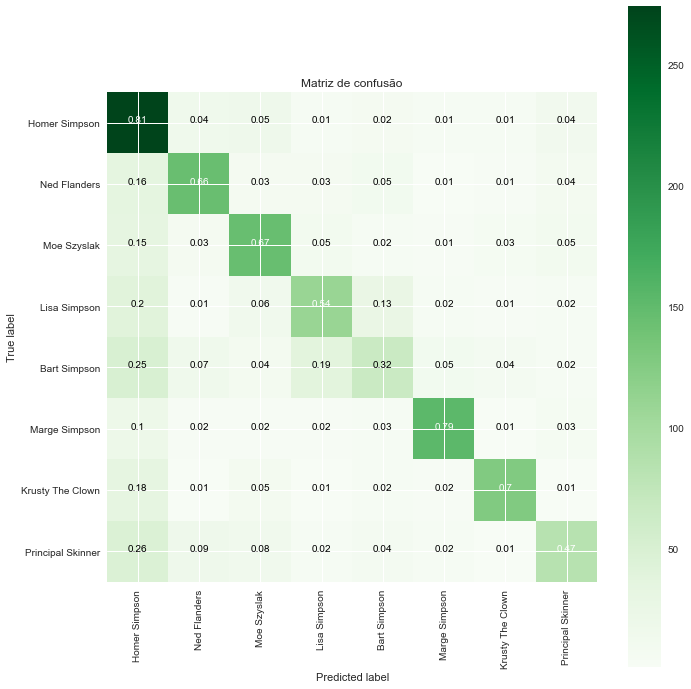

In [ ]:
resultados_modelo(y_test,y_pred_RF)

### Random Forest com One Hot Encoding

In [ ]:
model_RF_cat = RandomForestClassifier(n_jobs=-1, random_state=42)
model_RF_cat.fit(X_train.reshape(X_train.shape[0], -1), y_train_cat)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
y_pred_RF_cat = model_RF_cat.predict(X_test.reshape(X_test.shape[0], -1))

A acurácia deste modelo foi de 38.24%


                   precision    recall  f1-score   support

    Homer Simpson       0.24      1.00      0.39       337
     Ned Flanders       0.99      0.32      0.48       218
      Moe Szyslak       1.00      0.28      0.43       218
     Lisa Simpson       0.84      0.08      0.14       203
     Bart Simpson       0.91      0.05      0.09       201
    Marge Simpson       0.95      0.53      0.68       194
 Krusty The Clown       1.00      0.19      0.32       181
Principal Skinner       1.00      0.19      0.32       179

         accuracy                           0.38      1731
        macro avg       0.87      0.33      0.36      1731
     weighted avg       0.82      0.38      0.36      1731



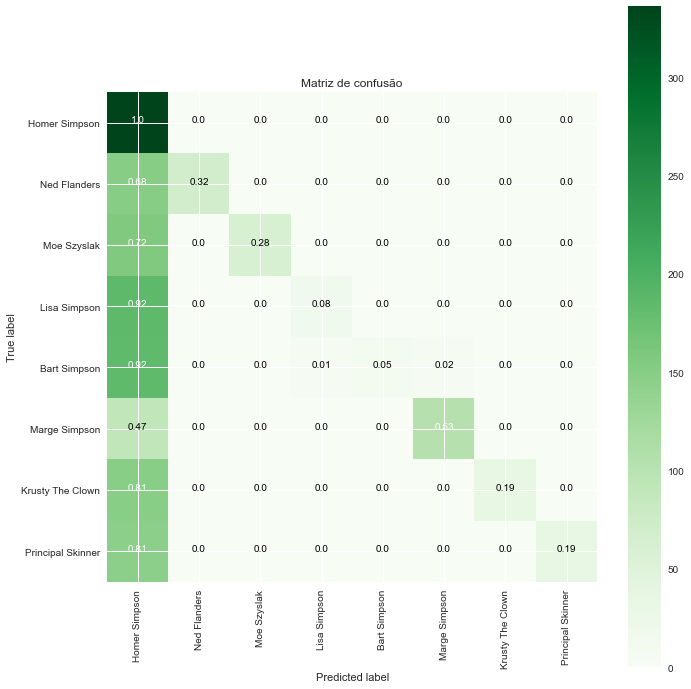

In [ ]:
y_pred_RF_cat_fin = []

for a in y_pred_RF_cat:
    y_pred_RF_cat_fin.append(a.tolist().index(max(a.tolist())))

resultados_modelo(y_test,y_pred_RF_cat_fin)

In [ ]:
data_example = y_pred_RF_cat[0]
print(data_example)

print(data_example.tolist().index(max(data_example.tolist())))

[0. 0. 0. 0. 0. 0. 0. 0.]
0


In [ ]:
i=0

for a in y_pred_RF_cat:
    if a.any() == y_pred_RF_cat[0].all():
        i+=1
        
print("O número de imagens não classificadas é de " + str(i))
print("O número de imagens total é de " + str(len(y_pred_RF_cat)))

O número de imagens não classificadas é de 1306
O número de imagens total é de 1731


### ResNet pré treinada com Integer Encoding

In [ ]:
tf.random.set_seed(0)
url="https://tfhub.dev/google/experts/bit/r50x1/in21k/object/1"

model_RN = tf.keras.Sequential([
    hub.KerasLayer(url, trainable=False),
])


model_RN.add(Dense(300, activation='relu'))
model_RN.add(Dense(100, activation='relu'))
model_RN.add(Dropout(0.2))
model_RN.add(BatchNormalization())


model_RN.add(Dense(num_classes, activation='softmax', kernel_initializer="glorot_normal",))

model_RN.build([None, img_size, img_size, 3])

epochs = 90
b_size = 100

s = epochs * len(X_train) // b_size  # number of steps in epochs (batch size = b_size)
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
callbacks = [early_stopping_cb]

model_RN.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"])

model_RN.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=b_size,
    validation_split=0.1,
    callbacks=callbacks,
)

Epoch 1/90
89/89 [==============================] - 59s 361ms/step - loss: 1.5141 - accuracy: 0.4560 - val_loss: 1.8903 - val_accuracy: 0.4373
Epoch 2/90
89/89 [==============================] - 31s 348ms/step - loss: 1.0180 - accuracy: 0.6462 - val_loss: 1.4237 - val_accuracy: 0.5240
Epoch 3/90
89/89 [==============================] - 31s 350ms/step - loss: 0.9283 - accuracy: 0.6803 - val_loss: 1.0850 - val_accuracy: 0.6544
Epoch 4/90
89/89 [==============================] - 31s 351ms/step - loss: 0.8149 - accuracy: 0.7277 - val_loss: 1.0135 - val_accuracy: 0.6616
Epoch 5/90
89/89 [==============================] - 31s 352ms/step - loss: 0.6892 - accuracy: 0.7729 - val_loss: 0.7525 - val_accuracy: 0.7615
Epoch 6/90
89/89 [==============================] - 31s 353ms/step - loss: 0.5925 - accuracy: 0.8034 - val_loss: 0.6643 - val_accuracy: 0.7880
Epoch 7/90
89/89 [==============================] - 32s 355ms/step - loss: 0.6332 - accuracy: 0.7834 - val_loss: 1.0255 - val_accuracy: 0.6901

In [ ]:
y_pred_RN = model_RN.predict(X_test)

A acurácia deste modelo foi de 77.7%


                   precision    recall  f1-score   support

    Homer Simpson       0.87      0.62      0.72       337
     Ned Flanders       0.78      0.79      0.79       218
      Moe Szyslak       0.70      0.83      0.76       218
     Lisa Simpson       0.86      0.85      0.86       203
     Bart Simpson       0.70      0.80      0.75       201
    Marge Simpson       0.73      0.84      0.78       194
 Krusty The Clown       0.90      0.89      0.89       181
Principal Skinner       0.69      0.70      0.69       179

         accuracy                           0.78      1731
        macro avg       0.78      0.79      0.78      1731
     weighted avg       0.79      0.78      0.78      1731



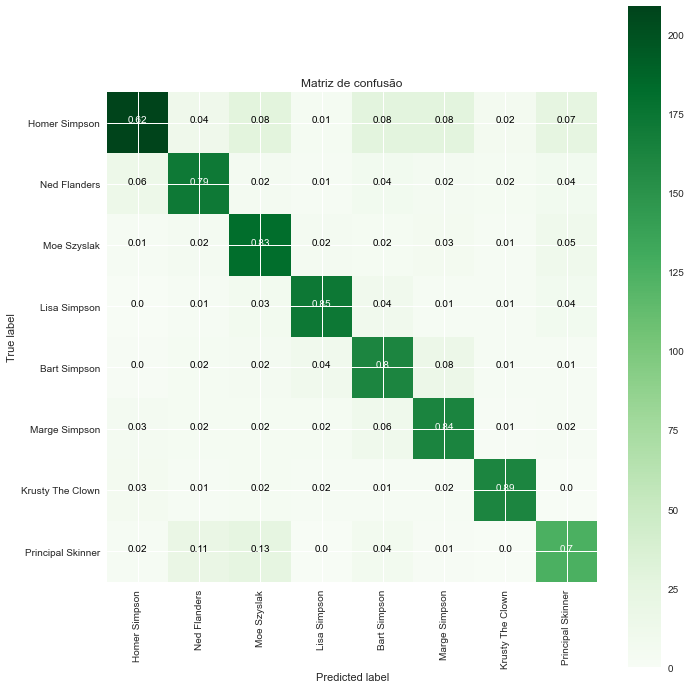

In [ ]:
y_pred_RN_fin = []

for a in y_pred_RN:
    y_pred_RN_fin.append(a.tolist().index(max(a.tolist())))
    
resultados_modelo(y_test,y_pred_RN_fin)

### ResNet pré treinada com One Hot Encoding

In [ ]:
tf.random.set_seed(0)
url="https://tfhub.dev/google/experts/bit/r50x1/in21k/object/1"

model_RN_cat = tf.keras.Sequential([
    hub.KerasLayer(url,trainable=False),
])


model_RN_cat.add(Dense(300, activation='relu'))
model_RN_cat.add(Dense(100, activation='relu'))
model_RN_cat.add(Dropout(0.2))
model_RN_cat.add(BatchNormalization())


model_RN_cat.add(Dense(num_classes, activation='softmax', kernel_initializer="glorot_normal",))

model_RN_cat.build([None, img_size, img_size, 3])

epochs = 90
b_size = 100

s = epochs * len(X_train) // b_size  # number of steps in epochs (batch size = b_size)
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
callbacks = [early_stopping_cb]

model_RN_cat.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"])


model_RN_cat.fit(
    X_train,
    y_train_cat,
    epochs=epochs,
    batch_size=b_size,
    validation_split=0.1,
    callbacks=callbacks,
)

Epoch 1/90
89/89 [==============================] - 52s 363ms/step - loss: 1.5171 - accuracy: 0.4558 - val_loss: 1.6867 - val_accuracy: 0.4271
Epoch 2/90
89/89 [==============================] - 31s 352ms/step - loss: 1.0387 - accuracy: 0.6396 - val_loss: 0.8295 - val_accuracy: 0.7309
Epoch 3/90
89/89 [==============================] - 32s 354ms/step - loss: 0.7819 - accuracy: 0.7380 - val_loss: 1.0091 - val_accuracy: 0.6799
Epoch 4/90
89/89 [==============================] - 32s 356ms/step - loss: 0.6551 - accuracy: 0.7846 - val_loss: 0.9337 - val_accuracy: 0.7309
Epoch 5/90
89/89 [==============================] - 32s 357ms/step - loss: 0.5899 - accuracy: 0.8030 - val_loss: 0.9140 - val_accuracy: 0.7278
Epoch 6/90
89/89 [==============================] - 32s 364ms/step - loss: 0.5974 - accuracy: 0.7983 - val_loss: 1.3827 - val_accuracy: 0.6279
Epoch 7/90
89/89 [==============================] - 33s 375ms/step - loss: 0.5245 - accuracy: 0.8246 - val_loss: 0.9071 - val_accuracy: 0.7166

In [ ]:
y_pred_RN_cat = model_RN_cat.predict(X_test)

A acurácia deste modelo foi de 79.9%


                   precision    recall  f1-score   support

    Homer Simpson       0.83      0.77      0.80       337
     Ned Flanders       0.76      0.80      0.78       218
      Moe Szyslak       0.77      0.80      0.79       218
     Lisa Simpson       0.80      0.89      0.84       203
     Bart Simpson       0.81      0.72      0.77       201
    Marge Simpson       0.73      0.85      0.79       194
 Krusty The Clown       0.85      0.91      0.88       181
Principal Skinner       0.85      0.66      0.75       179

         accuracy                           0.80      1731
        macro avg       0.80      0.80      0.80      1731
     weighted avg       0.80      0.80      0.80      1731



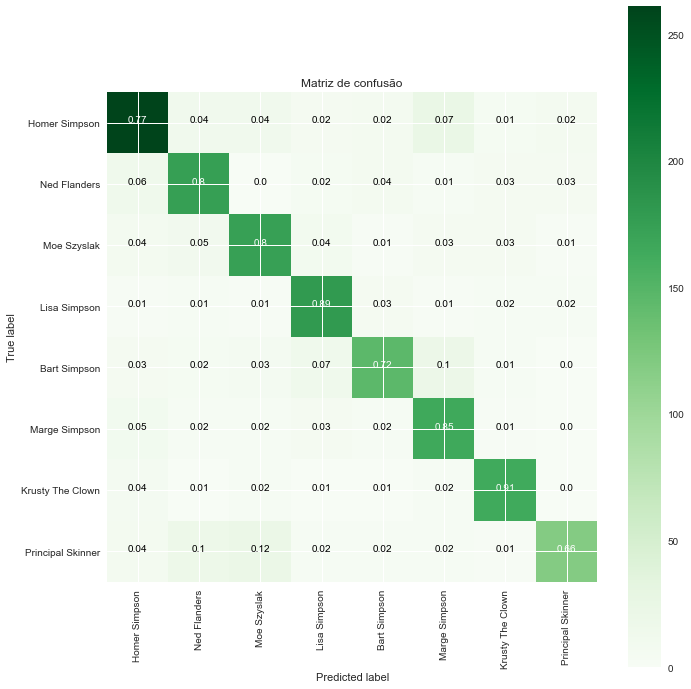

In [ ]:
y_pred_RN_cat_fin = []

for a in y_pred_RN_cat:
    y_pred_RN_cat_fin.append(a.tolist().index(max(a.tolist())))
    
resultados_modelo(y_test,y_pred_RN_cat_fin)

In [ ]:
BSasMS2 = []
for a,b,c in zip(y_test, y_pred_RN_cat_fin, range(len(X_test))):
    if b == 5:
        if a == 4:
            BSasMS2.append(c)

Exemplo de imagens do Bart Simpson classificadas como Marge Simpson


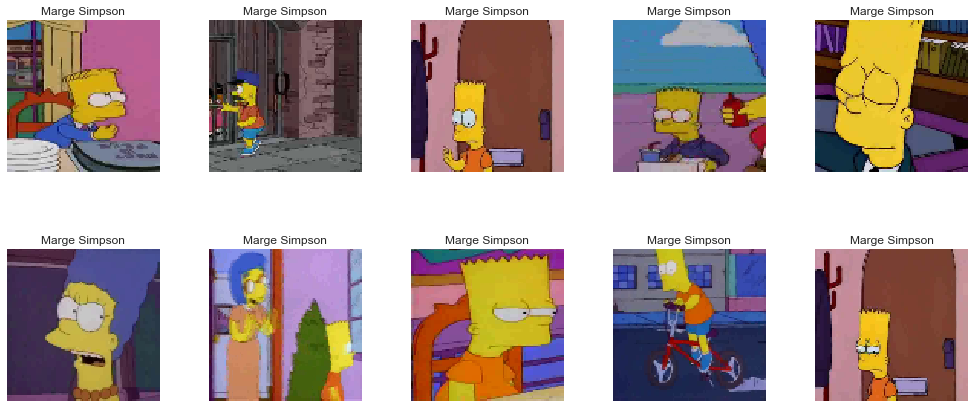

In [ ]:
#Imagens do dataset de teste com seus respectivos labels para vizualização e verificação da associação entre X e y.
n_rows = 2
n_cols = 5
plt.figure(figsize=(n_cols * 3.5, n_rows * 3.5))
print('Exemplo de imagens do Bart Simpson classificadas como Marge Simpson')
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_test[BSasMS2[index]], interpolation="nearest")
        plt.axis("off")
        name_char = all_characters_name[y_pred_RN_cat_fin[BSasMS2[index]]]
        plt.title(name_char, fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [ ]:
#Aqui se salva os modelos CNN para não ter que treiná-los
# model_RN.save('model_RN')
# model_RN_cat.save('model_RN_cat')

INFO:tensorflow:Assets written to: model_RN\assets


INFO:tensorflow:Assets written to: model_RN\assets


## Análise dos Resultados

&emsp;Para iniciar a análise, é importante comparar os modelos do mesmo classificador treinados com os labels no formato de integer encoding com os de one hot encoding. Para o random forest a diferença de acurácia entre os modelos é drástica (63,60% para o integer encoding e 38,24% para o one hot). Contudo, esta drástica diferença pode ser atribuido a um erro que ocorreu nos labels preditos. Para diversas imagens, o resultado do label predito foi uma lista somente com valores de 0. Isto significa que o modelo não atribuiu nenhum label para esta imagem, mas, ao verificar o valor máximo nesta lista, o python retorna que este se encontra no índice 0. Como consequência, é dito que para os labels onde nenhuma predição ocorreu, o resultado assumido é Homer Simpson. É exatamente isto que faz com que o recall do Homer neste caso seja de 100%, mas que sua precision seja a mais baixa entre os modelos treinados. Devido a este erro substancial, deve ser desconsiderado os resultados deste caso.

&emsp;Já para a ResNet-50, o label no formato de one hot encoding resultou em uma acurácia ligeiramente maior (79,9% em comparação com 77,7%). Pode-se dizer que isto é esperado pois, com o integer encoding, é possível que o modelo assuma que existem relações e ordens de importância entre as categorias que na realidade não existem neste caso.

&emsp;Agora, ao comparar as matrizes de confusão, percebe-se claramente uma diferença em relação a classificação do Homer Simpson com o Random Forest e com o CNN. Para o Random Forest o recall deste personagem é significativamente maior que sua precision. Isto provavelmente se deve ao maior número de imagens que ele possui no dataset, conforme explicitado anteriormente. O algarismo ficou tendencioso e passou a classificar outros personagens como Homer pois ele "percebeu" o seu maior número de imagens. Em contraste, o CNN se baseia mais na percepção de características físicas dos personagens, o que significa que o maior número de imagens não fez com que este algarismo classificasse outros personagens como Homer, mas sim o ajudou a detectar os personagens que realmente eram associados a este label.

&emsp;Outro fator mencionado antes foi a semelhança entre o Bart Simpson e a Lisa Simpson, e como isto poderia gerar confusão nos algarismos de classificação. No entanto, este efeito não ficou tão evidente quanto imaginado. Ele se mostra mais presente no Random Forest treinado com integer encoding, e a matriz de confusão nos mostra isto claramente. Contudo, para os modelos CNN, o Bart Simpson foi mais confundido com a Marge Simpson que com qualquer outro personagem. Dado a falta de semelhança entre ambos e características extremamente identificaveis da Marge, como seu cabelo grande e azul, fica difícil explicar como que estes labels são trocados tão frequentemente. Porém, ao plotar algumas das imagens que foram inicialmente classificadas como sendo o Bart Simpson no dataset original e que foram posteriormente classificadas como sendo a Marge pelo ResNet-50 treinado com One Hot Encoding, percebe-se algumas coisas interessantes. Em primeiro lugar, tem uma imagem classificada como sendo o Bart que claramente é a Marge. Isto pode ter ocorrido também no conjunto de treinamento o que pode ter afetado a classificação de ambos estes personagens. Além disso, há outras imagens onde há a presença de cabelo azul de outros personagens ou que o Bart usa um chapeu azul. Isto também pode gerar confusão, e também permite verificar que as imagens no dataset muitas vezes apresentam mais de um personagem.

&emsp;Novamente olhando para os modelos CNN, é possível identificar um erro de classificação já esperado. Em ambas as formas de treinamento para o CNN, os personagens mais confundidos foram o Principal Skinner com o Moe Szyslak. Isto é esperado pois ambos são homens magros com cabelo grisalho. Então, a confusão entre os dois é facilmente prevista. Outro fator facilmente previsto é a facilidade de classificar o Krusty The Clown. Em todos os modelos o f1-score deste personagem é um dos maiores. Sua face branca, cabelo caracteristico e nariz vermelho certamente auxiliam neste processo.

## Conclusão

&emsp;Com os resultados apresentados acima é possível perceber que muitas das expectativas que se tem ao fazer uma análise exploratória podem ser vistas na prática. Além disso, embora os modelos treinados não possuam acurácias das mais altas (especialmente considerando que uma classificação aleatoria resultaria em uma acurácia de 12,5%), é importante ressaltar que eles não foram otimizados e os recursos disponíveis foram limitados para que o treinamento fosse mais rápido e eficiente. No entanto, ainda é evidente que as imagens retiradas do dataset dos Simpsons podem ser processadas de tal forma a identificar os personagens, independente dos potenciais erros do dataset.